In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


# Bitclout Jupyter Notebook
For a list of all bitclout API endpoints, check https://docs.bitclout.com/devs/backend-api
Note that not all API endpoint are necessarily documented.
There are some that can be seen in the bitcloud backend code that do not appear in the published docs.

This python jupyter notebook will just go through calling some and showing how to go about navigating the blockchain with code.

**IMPORTANT:** It will probably not be possible to call some of these against the bitclout.com domain endpoints as I believe that may rate limit. It is best to have a node running yourself or perhaps know of a node that has unlimited API calls. Setting up a node is relatively painless, but best to be done on a machine with at 32gb ram and multiple tb's of disk space. At the low end, a dedicated host in the cloud can be found for around $40 USD per month.


In [6]:
# Here is the endpoint that we use
# Bitclout backend api is hosted on port 17001 by default, when using the supplied run config
endpoint = 'http://127.0.0.1:17001'

In [17]:
# Healthcheck API just returns a thumbs up or thumbs down by way of an http response
# 200 says that things are good.
import requests
import json

response = requests.get(endpoint+"/api/v0/health-check")
print(response)

<Response [200]>


Most of the Bitclout API endpoints are POST requests.

There are two ways to get user profile data. The first is through the get-single-profile request which retrieves information about a user. Another profile endpoint exists to retrieve numerous user profiles in a single API call. Sort of a bulk type of API call.

In [18]:
data = { 'Username':'Neonstoic'}
response = requests.post(endpoint+"/api/v0/get-single-profile", json=data)
print(response.text)

{"Profile":{"PublicKeyBase58Check":"BC1YLint2QNJWyNMX8kAiiTiYjT8yrTNYtzXKbGhXRoj7dPyNHboQLY","Username":"NeonStoic","Description":"ðŸ¤–AI ðŸš€DeFi ðŸ‘“AR ðŸ¥½VR ðŸ‘¾SciFi\nðŸ”®Futurism ðŸ“¸Photography ðŸ’»Code\nBuilding things\n\nProjects:\n @wecreate           @btclt_it\n @Bitlytics          @cloutfaucet\n @BitCloutBoutique\n","IsHidden":false,"IsReserved":false,"IsVerified":false,"Comments":null,"Posts":null,"CoinEntry":{"CreatorBasisPoints":500,"BitCloutLockedNanos":2889675320,"NumberOfHolders":101,"CoinsInCirculationNanos":14243483664,"CoinWatermarkNanos":14476097959},"CoinPriceBitCloutNanos":608631078,"StakeMultipleBasisPoints":12500,"StakeEntryStats":{"TotalStakeNanos":0,"TotalStakeOwedNanos":0,"TotalCreatorEarningsNanos":0,"TotalFeesBurnedNanos":0,"TotalPostStakeNanos":0},"UsersThatHODL":null},"IsBlacklisted":false,"IsGraylisted":false}



The previous API call takes the username (my username) and returns some details about the profile:
- PublicKeyBase58Check : This is the public key for the user. This is a super important key and is used for most of the other user API endpoints (as I'll show below).
- Description (self explanatory)
- IsReserved : indicates if the user was reserved. Think all the top held profiles like Elon.
- CoinEntry : This is a more important part of the response and is an object within the Profile JSON that provides the uer's creator coin details like number of Hodlers. Note that coin proce (CoinPriceBitCloutNanos) is outside of this.
- CoinPriceNanos : the user's creator coin price... in Nanos. **Important**: All API calls deal with $CLOUT in Nanos. 1 $CLOUT == 1,000,000,000 Nanos. Yes, 1 Billion Nanos per Bitclout.

Once you have the Publick key (PublicKeyBase58check), you can make some other API calls to retrieve other things for that user. For exmaple, let's get the user's profile image...

BC1YLint2QNJWyNMX8kAiiTiYjT8yrTNYtzXKbGhXRoj7dPyNHboQLY
200


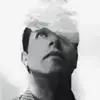

In [19]:
from IPython.display import Image, display

# Get profile picture for user id
data = { 'Username': 'Neonstoic'}
response = requests.post(endpoint+"/api/v0/get-single-profile", json=data)
if response.status_code == 200:
    userprofile = json.loads(response.text)['Profile']
    print(userprofile['PublicKeyBase58Check'])
    response = requests.get(endpoint+'/api/v0/get-single-profile-picture/'+userprofile['PublicKeyBase58Check'])
    print(response.status_code)
    display(Image(response.content))   
else:
    print("Profile not found")

Besides User data, you would probably be interested in transaction data.
Maybe you are interested in getting details about the *genesis block*. This is the first block, or block zero in the Bitclout blockchain.

In [5]:
# Get details for block 
from datetime import datetime

def getBlockInfo(height):
    # Call /api/v1/block to get details about a block passed to the function
    data = { 'Height':height, 'FullBlock':True }
    response = requests.post(endpoint+"/api/v1/block", json=data)

    # Return the JSON response
    respdata = json.loads(response.text)
    return respdata

# Retrieve Block ZERO details
data = getBlockInfo(0)
blockhash = data['Header']['BlockHashHex']
transactions = data['Transactions']

# timestamps in the blockchain are stored as epoch date (in seconds)
# timestamp can be converted in pythong using standard date-time functionality
timestamp = datetime.fromtimestamp(data['Header']['TstampSecs'])

print('Blockhash: ' + blockhash)
print(timestamp)

Blockhash: 5567c45b7b83b604f9ff5cb5e88dfc9ad7d5a1dd5818dd19e6d02466f47cbd62
2021-01-18 00:42:24


If you want to check out the genesis block in all its detailed details, you can use a bitclout block explorer here : https://explorer.bitclout.com/?query-node=https:%2F%2Fapi.bitclout.com&block-hash=5567c45b7b83b604f9ff5cb5e88dfc9ad7d5a1dd5818dd19e6d02466f47cbd62 If you do take a look, you can see a load of users to whom initial genesis block rewards were provided.

### Transaction Types
From the code *core/lib/network.go*
- UNSET
- BLOCK_REWARD
- BASIC_TRANSFER
- BITCOIN_EXCHANGE
- PRIVATE_MESSAGE
- SUBMIT_POST
- UPDATE_PROFILE
- UPDATE_BITCOIN_USD_EXCHANGE_RATE
- FOLLOW
- LIKE
- CREATOR_COIN
- CREATOR_COIN_TRANSFER
- SWAP_IDENTITY
- UPDATE_GLOBAL_PARAMS

So as an experiment, let's do the following :
- Determine what the most recent block height is
- Loop through from 0 to the max block height and
  - Get all the "UPDATE_PROFILE" transactions and store the public key for them.

Theoretically, doing the above will produce a list of all the users in Bitclout.

In [7]:
import requests
import json

#Let's loop through blocks, looking for updated profiles, which should give us all the profiles
blocknum = 0

#Get latest header height from node-info endpoint (which is strangely a POST with no body. Why not GET?)
def getChainHeight():
    response = requests.post(endpoint+'/api/v1/node-info', json={})
    respdata = json.loads(response.text)
    chainheight = respdata['BitCloutStatus']['LatestBlockHeight']
    return chainheight

height = getChainHeight()
f = open('users.txt', 'w')

# NOTE - Just setting height to 10 for now
# Otherwise it takes a really long time. Just calling this 10
# times while calling into a node that I host took over 100 seconds.abs
height = 10

# Do loop
for n in range(0, height):
    data = getBlockInfo(n)

    update_txns = []

    for tx in data['Transactions']:
        if tx['TransactionType'] == 'UPDATE_PROFILE':
            update_txns.append(tx)
            user_public_key = tx['Outputs'][0]['PublicKeyBase58Check']
            f.write(user_public_key + '\n')

f.close()
print("done!")


done!


In [23]:
# Let's get all the image URL's for the most recent block
import requests
import json
from IPython.display import Image, display

#Get latest header height from node-info endpoint (which is strangely a POST with no body. Why not GET?)
def getChainHeight():
    response = requests.post(endpoint+'/api/v1/node-info', json={})
    respdata = json.loads(response.text)
    chainheight = respdata['BitCloutStatus']['LatestBlockHeight']
    return chainheight

def getBlockInfo(height):
    # Call /api/v1/block to get details about a block passed to the function
    data = { 'Height':height, 'FullBlock':True }
    response = requests.post(endpoint+"/api/v1/block", json=data)

    # Return the JSON response
    respdata = json.loads(response.text)
    return respdata


def getTransaction(transactionHash):
    data = {'TxnHashHex':transactionHash}
    response = requests.post(endpoint+'/api/v0/submit-transaction', json=data)
    respdata = json.loads(response.text)
    return respdata

def getPost(hash):
    data = {'PostHashHex':hash}
    response = requests.post(endpoint+'/api/v0/get-single-post',json=data)
    respdata = {}
    if response.status_code == 200:
        respdata = json.loads(response.text)
    else:
        print('Not Found!')
    return respdata

def showImages(post):
    reclout = post['RecloutedPostEntryResponse']
    if reclout != None:
        showImages(reclout)
    imgurls = post['ImageURLs']
    if imgurls != None:                
        print(post['Body'])
        for url in imgurls:
            print(url)
            imgresp = requests.get(url)
            if imgresp.status_code == 200:
                display(Image(imgresp.content))

height = getChainHeight()

data = getBlockInfo(height)

for tx in data['Transactions']:
    if tx['TransactionType'] == 'SUBMIT_POST':
        posthash = tx['TransactionMetadata']['SubmitPostTxindexMetadata']['PostHashBeingModifiedHex']

        post = getPost(posthash)
        showImages(post['PostFound'])

TypeError: write() argument must be str, not dict

In [2]:
%history -g  -f history.json